In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
#import argparse
from statannot import add_stat_annotation

#stats
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
from pingouin import kruskal
from pybedtools import BedTool
import scikit_posthocs as sp

In [2]:
# parser = argparse.ArgumentParser(description='OpenChromatin_plots')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Chromatin_bp_covered', type=str, help='Input location of bp covered of chromatin in promoters text file')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')
# args = parser.parse_args()
dependent_variable = 'chromatin_coverage'

In [3]:
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
output_folder_name_rootshoot = 'RootShootIntersect/'
output_folder_name_root = 'Root/'
output_folder_name_shoot = 'Shoot/'
output_folder_name_promoter = 'promoters_5UTR/'

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
RootChomatin_bp_covered = f'../../data/output/{file_names}/chromatin_coverage/promoters_5UTRRootOpenChrom.bp_covered.txt'
ShootChomatin_bp_covered = f'../../data/output/{file_names}/chromatin_coverage/promoters_5UTRShootOpenChrom.bp_covered.txt'
RootShootIntersect_bp_covered = f'../../data/output/{file_names}/chromatin_coverage/promoters_5UTRShootRootIntersectOpenChrom.bp_covered.txt'

In [5]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

In [6]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

In [7]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

In [8]:
def percent_coverage(bp_covered):
    """function to calculate the % coverage from the output file of bedtools coverage"""

    coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot','strand','source', 'type', 'dot2', 'details', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered']
    coverage_df.columns = col
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

    #remove unnecessary columns
    coverage_df_reduced_columns = coverage_df[['chr','start','stop','AGI','strand', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered','percentage_bases_covered']]
    return coverage_df_reduced_columns

In [9]:
def merge_genecategories(df, gene_categories):
    """merge df with gene categories"""
    #read in gene categories
    gene_cats = pd.read_csv(gene_categories,sep='\t', header=None)
    gene_cats.columns = ['AGI','gene_type']
    #merge to limit to genes of interest
    df_categories = pd.merge(gene_cats, df, how='left', on='AGI')
    return df_categories

In [28]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", "variable", "control"]
    plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    box_pairs=[("constitutive", "variable"),("constitutive", "control"),("variable", "control")]
    #make empty list of p_values
    p_values = []
    #populate the list of p_values accoridng to the box_pairs
    for pair in box_pairs:
        print(pair)
        #select p value for each pair
        p = stat.loc[pair[0],pair[1]]
        p_values.append(p)


    
    #add stats annotation to the plot
    test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                      box_pairs=box_pairs,
                                      text_format='star',
                                      loc='outside',verbose=2,
                                      perform_stat_test=False,
                                       pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [11]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [12]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [13]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [14]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)    

In [15]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [16]:
# def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
#     """function to make and save plot"""
#     #allow colour codes in seaborn
#     sns.set(color_codes=True)
#     sns.set_style("whitegrid")
#     #plot
#     plot = sns.catplot(x=x_variable, y=y_variable, data=df, kind=plot_kind,order=["constitutive", "variable", "control"])
#     #plot points
#     ax = sns.swarmplot(x=x_variable, y=y_variable, data=df, color=".25",order=["constitutive", "variable", "control"])
#     #change axes labels
#     plt.ylabel(y_label)
#     plt.xlabel(x_label)
#     #save figure
#     ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')
    

In [17]:

def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters and the chromatin % bp covered"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [18]:
#add % coverage column
rootshootchromatin_coverage = percent_coverage(RootShootIntersect_bp_covered)
rootchromatin_coverage = percent_coverage(RootChomatin_bp_covered)
shootchromatin_coverage = percent_coverage(ShootChomatin_bp_covered)

In [19]:
#add gene categories to the df
cats_rootshoot = merge_genecategories(rootshootchromatin_coverage, Czechowski_gene_categories)
cats_root = merge_genecategories(rootchromatin_coverage, Czechowski_gene_categories)
cats_shoot = merge_genecategories(shootchromatin_coverage, Czechowski_gene_categories)

('constitutive', 'variable')
('constitutive', 'control')
('variable', 'control')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

constitutive v.s. variable: Custom statistical test, P_val:1.387e-04
variable v.s. control: Custom statistical test, P_val:5.211e-09
constitutive v.s. control: Custom statistical test, P_val:1.547e-01


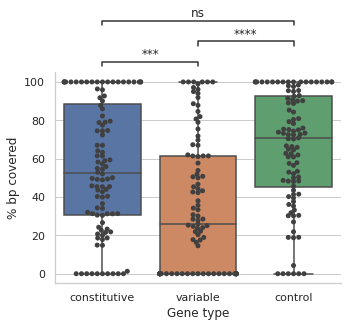

In [29]:
#Czechowski_gene_categories box plot root-shoot intersect
output_folder_name = output_folder_name_rootshoot
make_plot(cats_rootshoot,'gene_type','percentage_bases_covered','Gene type','% bp covered', f'Czechowski_{dependent_variable}', 'box')

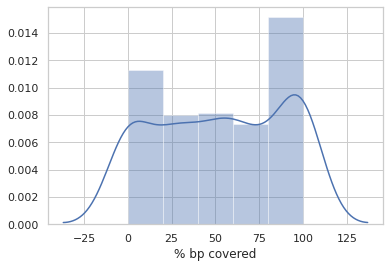

In [63]:
#all promoter distribution plot root shoot intersect
all_prom_distribution(cats_rootshoot,'percentage_bases_covered', '% bp covered', f'{dependent_variable}_allproms')

# root shoot intercept stats

In [30]:
df = cats_rootshoot
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [31]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=0.9204057455062866, pvalue=1.4790782188356388e-05)
variable: ShapiroResult(statistic=0.8534948825836182, pvalue=1.5999207292338724e-08)
control: ShapiroResult(statistic=0.9162167310714722, pvalue=8.91562467586482e-06)


## not normal

In [32]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=1.9922983447067977, pvalue=0.13820016125258577)

## fail to reject null hypothesis that variances are equal



In [33]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,54.923227,33.413690,0.0,30.526230,52.470325,88.315722,100.0
control,100.0,65.073291,29.881224,0.0,45.079023,70.624040,92.608697,100.0
variable,100.0,34.986866,35.126386,0.0,0.000000,25.672415,61.421593,100.0


In [34]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,37.756535,6.328090e-09


## significant difference

In [35]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,1.546566e-01,1.387438e-04
control,0.154657,-1.000000e+00,5.210707e-09
variable,0.000139,5.210707e-09,-1.000000e+00


# Root open chromatin stats

In [46]:
df = cats_root
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [47]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.8371602296829224, 4.091839755915316e-09)
variable: (0.858252763748169, 2.422665090762166e-08)
control: (0.7377145886421204, 4.4873835550185426e-12)


In [48]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=11.214263297743079, pvalue=2.017616097273199e-05)

In [49]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,66.616564,34.887537,0.0,37.52984,79.77325,100.0,100.0
control,100.0,79.122700,28.399399,0.0,71.92290,87.85234,100.0,100.0
variable,100.0,55.994815,38.445245,0.0,21.13460,61.51730,100.0,100.0


In [50]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,19.015054,0.000074


In [51]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,0.062796,0.121437
control,0.062796,-1.000000,0.000039
variable,0.121437,0.000039,-1.000000


## constitutive and control significantly higher than variable

# Shoot open chromatin stats

In [53]:
df = cats_shoot
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [54]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.9055484533309937, 2.602789436423336e-06)
variable: (0.8583513498306274, 2.4437856183112672e-08)
control: (0.8628171682357788, 3.636630907521976e-08)


In [55]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=1.7011474765261931, pvalue=0.1842471020791585)

In [56]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,58.228217,33.896543,0.0,31.375965,55.836035,96.004995,100.0
control,100.0,69.025035,31.662213,0.0,50.563703,78.070345,100.000000,100.0
variable,100.0,37.968656,36.379025,0.0,0.000000,28.159715,67.058363,100.0


In [57]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,37.767048,6.294914e-09


In [58]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,1.151705e-01,2.105969e-04
control,0.115170,-1.000000e+00,4.446989e-09
variable,0.000211,4.446989e-09,-1.000000e+00


## constitutive and control significantly higher than variable